poverty: by town <br>
hs_completion: by town <br>
n_households: by zip <br>
med_income: by zip <br>
population & density: by zip <br>
crime_rate: by town <br>
students_per_teacher: by town

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, r2_score
from sklearn.decomposition import PCA

import requests
from bs4 import BeautifulSoup

import pickle
import time

In [2]:
inc = pd.read_csv('./data/inc.csv')

In [3]:
pd.set_option('display.max_columns', 30)
inc.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,state,town,poverty,hs_completion,townstate,ZCTA,n_households,med_income,population,density,city,state_id,state_name,lat,lng,crime_rate,students_per_teacher,property_crime,violent_crime
0,0,0,0,Alabama,Abbeville,20.7,79.1,"Abbeville, Alabama",36310,2555,40186,6055,12.2,Abbeville,AL,Alabama,31.60296,-85.21630,62.0,13.000000,51.0,11.0
1,1,1,1,Alabama,Adamsville,16,83.5,"Adamsville, Alabama",35005,2792,50271,7528,89.3,Adamsville,AL,Alabama,33.59515,-87.00089,269.0,17.666667,250.0,19.0
2,2,2,2,Alabama,Addison,34.2,85.1,"Addison, Alabama",35540,1075,45074,2436,12.6,Addison,AL,Alabama,34.23388,-87.18817,15.0,15.500000,14.0,1.0
3,3,3,3,Alabama,Akron,48.7,62.8,"Akron, Alabama",35441,372,36731,1089,6.1,Akron,AL,Alabama,32.85374,-87.73861,NaN,NaN,NaN,NaN
4,4,4,4,Alabama,Alabaster,11.1,88.8,"Alabaster, Alabama",35007,8628,69691,26328,270.8,Alabaster,AL,Alabama,33.21591,-86.79717,585.0,18.571429,488.0,97.0


In [4]:
inc['townstate'].value_counts()

Houston, Texas                  97
New York, New York              69
Los Angeles, California         65
San Antonio, Texas              59
Miami, Florida                  56
                                ..
Thayer, Iowa                     1
Gray, Maine                      1
Emmonak, Alaska                  1
Society Hill, South Carolina     1
Haysi, Virginia                  1
Name: townstate, Length: 16187, dtype: int64

### Get counties for gini index

In [5]:
counties = pd.read_csv('./data/uscities.csv')

In [6]:
counties.head()

,city,city_ascii,state_id,state_name,county_fips,county_name,county_fips_all,county_name_all,lat,lng,population,density,source,military,incorporated,timezone,ranking,zips,id
0,South Creek,South Creek,WA,Washington,53053,Pierce,53053,Pierce,46.9994,-122.3921,2500.0,125.0,polygon,False,True,America/Los_Angeles,3,98580 98387 98338,1840042075
1,Roslyn,Roslyn,WA,Washington,53037,Kittitas,53037,Kittitas,47.2507,-121.0989,947.0,84.0,polygon,False,True,America/Los_Angeles,3,98941 98068 98925,1840019842
2,Sprague,Sprague,WA,Washington,53043,Lincoln,53043,Lincoln,47.3048,-117.9713,441.0,163.0,polygon,False,True,America/Los_Angeles,3,99032,1840021107
3,Gig Harbor,Gig Harbor,WA,Washington,53053,Pierce,53053,Pierce,47.3352,-122.5968,9507.0,622.0,polygon,False,True,America/Los_Angeles,3,98332 98335,1840019855
4,Lake Cassidy,Lake Cassidy,WA,Washington,53061,Snohomish,53061,Snohomish,48.0639,-122.0920,3591.0,131.0,polygon,False,True,America/Los_Angeles,3,98223 98258 98270,1840041959


In [7]:
counties['townstate'] = counties['city'] + ', ' + counties['state_name']

In [8]:
tempcounties = counties[['county_name', 'townstate']]

In [9]:
print(inc.shape)
inc = pd.merge(inc, tempcounties, left_on = 'townstate', right_on = 'townstate')
print(inc.shape)

(21167, 22)
(20705, 23)


In [10]:
inc['countystate'] = inc['county_name'] + ', ' + inc['state']

### Get Gini

In [11]:
gini = pd.read_csv('./data/gini.csv')

In [12]:
gini.head()

,GEO_ID,NAME,B19083_001E,B19083_001M
0,id,Geographic Area Name,Estimate!!Gini Index,Margin of Error!!Gini Index
1,0500000US01003,"Baldwin County, Alabama",0.4725,0.0271
2,0500000US01015,"Calhoun County, Alabama",0.4650,0.0292
3,0500000US01043,"Cullman County, Alabama",0.4981,0.0572
4,0500000US01049,"DeKalb County, Alabama",0.5003,0.0416


In [13]:
gini.shape

(839, 4)

In [14]:
gini = gini[['NAME', 'B19083_001E']]

In [15]:
gini.drop([0], inplace = True)
gini.reset_index(drop = True, inplace = True)

In [16]:
gini.columns = ['countystate', 'gini']

In [17]:
gini.head()

,countystate,gini
0,"Baldwin County, Alabama",0.4725
1,"Calhoun County, Alabama",0.4650
2,"Cullman County, Alabama",0.4981
3,"DeKalb County, Alabama",0.5003
4,"Elmore County, Alabama",0.4162


In [18]:
def clean_county(county):
    words = [' County', ' Parish', ' Municipio', ' city']
    for word in words:
        if word in county:
            return county.replace(word, '')
    return county

In [19]:
gini['countystate'] = gini['countystate'].apply(clean_county)

In [20]:
gini.head()

,countystate,gini
0,"Baldwin, Alabama",0.4725
1,"Calhoun, Alabama",0.4650
2,"Cullman, Alabama",0.4981
3,"DeKalb, Alabama",0.5003
4,"Elmore, Alabama",0.4162


In [21]:
gini[gini['countystate'].duplicated(keep=False)]

,countystate,gini
302,"Baltimore, Maryland",0.4499
315,"Baltimore, Maryland",0.5158
396,"St. Louis, Missouri",0.4920
397,"St. Louis, Missouri",0.5056
759,"Roanoke, Virginia",0.4088
772,"Roanoke, Virginia",0.5099


In [22]:
# todo: average among duplicates (few duplicates)
gini = gini.drop_duplicates(subset='countystate', keep='first').reset_index(drop=True)

In [23]:
print(inc.shape)
inc = pd.merge(inc, gini, left_on = 'countystate', right_on = 'countystate', how='left')
print(inc.shape)

(20705, 24)
(20705, 25)


In [24]:
# impute missing gini
# todo: use knn with lat/lon

inc['gini'] = pd.to_numeric(inc['gini'])
inc['gini_is_missing'] = inc['gini'].isnull().astype(int)
inc['gini'] = inc['gini'].fillna(inc['gini'].mean())

In [27]:
inc.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,state,town,poverty,hs_completion,townstate,ZCTA,n_households,med_income,population,density,city,state_id,state_name,lat,lng,crime_rate,students_per_teacher,property_crime,violent_crime,county_name,countystate,gini,gini_is_missing
0,0,0,0,Alabama,Abbeville,20.7,79.1,"Abbeville, Alabama",36310,2555,40186,6055,12.2,Abbeville,AL,Alabama,31.60296,-85.21630,62.0,13.000000,51.0,11.0,Henry,"Henry, Alabama",0.462122,1
1,1,1,1,Alabama,Adamsville,16,83.5,"Adamsville, Alabama",35005,2792,50271,7528,89.3,Adamsville,AL,Alabama,33.59515,-87.00089,269.0,17.666667,250.0,19.0,Jefferson,"Jefferson, Alabama",0.495200,0
2,2,2,2,Alabama,Addison,34.2,85.1,"Addison, Alabama",35540,1075,45074,2436,12.6,Addison,AL,Alabama,34.23388,-87.18817,15.0,15.500000,14.0,1.0,Winston,"Winston, Alabama",0.462122,1
3,3,3,3,Alabama,Akron,48.7,62.8,"Akron, Alabama",35441,372,36731,1089,6.1,Akron,AL,Alabama,32.85374,-87.73861,NaN,NaN,NaN,NaN,Hale,"Hale, Alabama",0.462122,1
4,4,4,4,Alabama,Alabaster,11.1,88.8,"Alabaster, Alabama",35007,8628,69691,26328,270.8,Alabaster,AL,Alabama,33.21591,-86.79717,585.0,18.571429,488.0,97.0,Shelby,"Shelby, Alabama",0.458900,0


In [26]:
inc.shape

(11128, 25)

### Address the nulls

In [5]:
inc.isnull().sum()

Unnamed: 0                  0
Unnamed: 0.1                0
Unnamed: 0.1.1              0
state                       0
town                        0
poverty                     0
hs_completion               0
townstate                   0
ZCTA                        0
n_households                0
med_income                  0
population                  0
density                     0
city                        0
state_id                    0
state_name                  0
lat                         0
lng                         0
crime_rate              14409
students_per_teacher     4574
property_crime          14410
violent_crime           14409
dtype: int64

In [6]:
inc.dropna(inplace = True)

In [7]:
inc.shape

(6304, 22)

In [9]:
# Drop unnecessary cols
inc.drop(
    columns = [
        'Unnamed: 0', 
        'Unnamed: 0.1',
        'Unnamed: 0.1.1',
        'city',
        'state_id'
    ], 
    inplace = True)

In [10]:
inc.head()

,state,town,poverty,hs_completion,townstate,ZCTA,n_households,med_income,population,density,state_name,lat,lng,crime_rate,students_per_teacher,property_crime,violent_crime
0,Alabama,Abbeville,20.7,79.1,"Abbeville, Alabama",36310,2555,40186,6055,12.2,Alabama,31.60296,-85.21630,62.0,13.000000,51.0,11.0
1,Alabama,Adamsville,16,83.5,"Adamsville, Alabama",35005,2792,50271,7528,89.3,Alabama,33.59515,-87.00089,269.0,17.666667,250.0,19.0
2,Alabama,Addison,34.2,85.1,"Addison, Alabama",35540,1075,45074,2436,12.6,Alabama,34.23388,-87.18817,15.0,15.500000,14.0,1.0
4,Alabama,Alabaster,11.1,88.8,"Alabaster, Alabama",35007,8628,69691,26328,270.8,Alabama,33.21591,-86.79717,585.0,18.571429,488.0,97.0
5,Alabama,Alabaster,11.1,88.8,"Alabaster, Alabama",35114,3022,80948,8624,223.3,Alabama,33.22306,-86.87245,585.0,18.571429,488.0,97.0


**Fix Types**

In [27]:
inc['gini'] = inc['gini'].astype(float)

In [11]:
inc['poverty'] = inc['poverty'].astype(float)

In [12]:
inc['hs_completion'] = inc['hs_completion'].astype(float)

### Fix 0 population

In [13]:
# 15 rows have 0 for population which causes infinity crime rate per capita
inc['population'].value_counts()

0        15
1464      4
7762      4
3708      4
2274      4
         ..
7133      1
9191      1
17522     1
10223     1
19871     1
Name: population, Length: 5588, dtype: int64

In [14]:
inc['n_households'].value_counts()

0        61
5848      6
798       5
1470      5
2902      5
         ..
7121      1
3023      1
974       1
13260     1
4100      1
Name: n_households, Length: 4701, dtype: int64

In [15]:
# Fill the 0 population towns
inc.loc[inc['population'] == 0, 'population'] = 100 #inc['population'].median()

In [16]:
# Fill the 0 household towns
inc.loc[inc['n_households'] == 0, 'n_households'] = 10

In [17]:
inc['population'].value_counts()

100      15
3708      4
7762      4
10842     4
6572      4
         ..
7133      1
9191      1
17522     1
10223     1
8192      1
Name: population, Length: 5588, dtype: int64

In [18]:
# Target variable: crime rate per capita
#inc['crime_rate_pc'] = inc['crime_rate'] / inc['n_households']
inc['crime_rate_pc'] = inc['crime_rate'] / inc['population']

### Grouping by town

- dataframe is by zip so towns with multiple zips are counted multiple times
- should be grouped by town

- These should be averaged
 - med_income
 - hs_completion
 - poverty
 - density

In [21]:
# dataframe is by zip so towns with multiple zips are counted multiple times
# to rectify, we will groupby townstate, then re add the state col
inc['townstate'].value_counts()

Naples, Florida            15
Tyler, Texas                9
Saginaw, Michigan           7
Vero Beach, Florida         6
Johnstown, Pennsylvania     6
                           ..
Sutherlin, Oregon           1
Sullivan City, Texas        1
Odenville, Alabama          1
Social Circle, Georgia      1
Avon Park, Florida          1
Name: townstate, Length: 5771, dtype: int64

In [37]:
#testinc = inc.groupby('townstate', as_index = False).mean()

In [38]:
#testinc.shape

In [39]:
#testinc['state'] = testinc['townstate'].apply(lambda x: x.split(', ')[1])

In [40]:
#testinc[['n_households', 'population']] = inc.groupby('townstate').sum()[['n_households', 'population']]

In [41]:
### n_households & population must be summed by town
#testinc[['n_households', 'population']] = inc.groupby('townstate', as_index = False).sum()[['n_households','population']]

In [42]:
#testinc.head()

In [43]:
# Drop outliers
#testinc = testinc.loc[(testinc['crime_rate_pc'] > 0) & (testinc['crime_rate_pc'] < 40)]

In [19]:
# Drop outliers
testinc = inc.loc[(inc['crime_rate_pc'] > 0) & (inc['crime_rate_pc'] < 1)]

In [20]:
testinc.shape

(6082, 18)

### Modeling

### K Means Clustering

In [21]:
features = [
    'med_income',
    'poverty',
    'hs_completion',
    'density',
    'students_per_teacher',
    #'gini',
    'crime_rate_pc',
    'property_crime',
    'violent_crime',
]
X = testinc[features]

In [22]:
X.corr()

,med_income,poverty,hs_completion,density,students_per_teacher,crime_rate_pc,property_crime,violent_crime
med_income,1.000000,-0.652263,0.513570,0.172520,0.079249,-0.039383,0.148211,-0.026075
poverty,-0.652263,1.000000,-0.595857,-0.085207,-0.040227,0.083481,-0.026543,0.117396
hs_completion,0.513570,-0.595857,1.000000,0.081457,0.032067,0.020415,0.096598,-0.066695
density,0.172520,-0.085207,0.081457,1.000000,0.044453,0.329311,0.262832,0.218620
students_per_teacher,0.079249,-0.040227,0.032067,0.044453,1.000000,0.024979,0.120914,0.068551
crime_rate_pc,-0.039383,0.083481,0.020415,0.329311,0.024979,1.000000,0.331862,0.296302
property_crime,0.148211,-0.026543,0.096598,0.262832,0.120914,0.331862,1.000000,0.605813
violent_crime,-0.026075,0.117396,-0.066695,0.218620,0.068551,0.296302,0.605813,1.000000


In [23]:
ss = StandardScaler()
X_scaled = ss.fit_transform(X)

In [24]:
km = KMeans(n_clusters = 2, random_state = 42)

In [25]:
km.fit(X_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [26]:
testinc['cluster'] = km.labels_

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [27]:
centroids = testinc.groupby('cluster')[features].mean()
centroids

,med_income,poverty,hs_completion,density,students_per_teacher,crime_rate_pc,property_crime,violent_crime
cluster,,,,,,,,
0,68220.023147,10.420027,91.613318,359.253438,16.079501,0.018126,239.085542,24.370681
1,41819.053531,25.111512,79.992744,121.146469,15.098483,0.020490,198.904547,32.638504


In [28]:
ss.inverse_transform(km.cluster_centers_)

array([[6.82085283e+04, 1.04223265e+01, 9.16084143e+01, 3.59034965e+02,
        1.60777714e+01, 1.81233937e-02, 2.38971840e+02, 2.43590345e+01],
       [4.18130797e+04, 2.51187803e+01, 7.99899645e+01, 1.21203098e+02,
        1.50995146e+01, 2.04940729e-02, 1.98988061e+02, 3.26550500e+01]])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


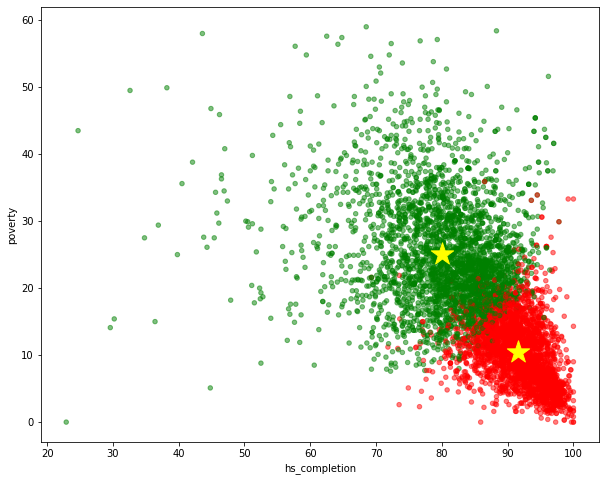

In [29]:
colors = ['red', 'green']
testinc['color'] = testinc['cluster'].map(lambda p: colors[p])

ax = testinc.plot(    
    kind = 'scatter', 
    x = 'hs_completion', y = 'poverty',
    figsize = (10,8),
    alpha = .5,
    c = testinc['color']
)

centroids.plot(
    kind = 'scatter', 
    x = 'hs_completion', y = 'poverty', 
    marker = '*', c = 'yellow', s = 550,
    ax = ax
);

In [36]:
silhouette_score(X_scaled, km.labels_)

0.23306570650606084

In [82]:
scores = []
for k in range(2, 30):
    cl = KMeans(n_clusters = k, random_state = 42)
    cl.fit(X_scaled)
    inertia = cl.inertia_
    sil = silhouette_score(X_scaled, cl.labels_)
    scores.append((k, inertia, sil))

In [83]:
score_df = pd.DataFrame(scores, columns = ['k', 'inertia', 'sil'])
score_df.head()

,k,inertia,sil
0,2,32550.476542,0.260867
1,3,27569.622517,0.266670
2,4,23671.509800,0.248402
3,5,20316.041168,0.249393
4,6,18593.754376,0.253709


### Regression

In [58]:
features = [
    'med_income',
    'poverty',
    'hs_completion',
    'density',
    'students_per_teacher',
    'n_households',
    #'gini',
    #'population'
]
X = testinc[features]
y = testinc['crime_rate']

In [59]:
pf = PolynomialFeatures()
X_poly = pf.fit_transform(X)

In [60]:
ss = StandardScaler()
X_scaled = ss.fit_transform(X_poly)

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state = 42)

In [62]:
rf = RandomForestRegressor() # random_state = 27
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.5526546814985553

In [63]:
lr = LinearRegression()
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.5257777493882156

In [64]:
lr.coef_

array([-1.28076969e-14,  3.25173452e+01,  4.28255293e+01,  7.63374220e+00,
        2.95101411e+01, -2.52368961e+01,  4.38727260e+02,  9.93007158e+00,
       -1.95604633e+01, -5.39275105e+01,  4.66078168e+01,  6.68182788e+01,
       -8.13747424e+01, -6.44013972e+01,  3.19163468e+01,  5.14229799e+01,
        3.97059382e+01,  1.34097349e+01,  1.42988426e+01,  1.92522720e+01,
       -4.81078119e+01, -1.12832350e+02, -5.35574004e+01, -2.72682785e+01,
       -1.93538493e+01,  9.84690147e+00,  2.13573186e+01, -1.19769768e+02])